# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import ks_2samp

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Separar os três últimos meses como safras de validação out of time (oot), utilizadno a data máxima como referência
oot = df[df['data_ref'] >= (df['data_ref'].max() - pd.DateOffset(months=3))]
oot

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
550000,2015-12-01,11675,M,S,S,0,Assalariado,Superior completo,Casado,Casa,44,13.082192,2.0,45242.72,False
550001,2015-12-01,5595,F,N,N,0,Assalariado,Médio,Casado,Casa,40,2.871233,2.0,892.44,False
550002,2015-12-01,7725,M,S,S,0,Assalariado,Médio,Casado,Casa,51,32.619178,2.0,74949.48,False
550003,2015-12-01,509,M,S,S,0,Assalariado,Médio,Casado,Casa,45,11.865753,2.0,7910.84,False
550004,2015-12-01,13736,M,S,S,2,Servidor público,Médio,Casado,Estúdio,35,10.876712,4.0,11652.96,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
df.data_ref.value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [5]:
# Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
# Descrição geral da base de dados
total_rows = df.shape[0]
total_columns = df.shape[1]

# Contagem de linhas por mês em 'data_ref'
rows_per_month = df['data_ref'].value_counts().sort_index()

total_rows, total_columns, rows_per_month

(750000,
 15,
 2015-01-01    50000
 2015-02-01    50000
 2015-03-01    50000
 2015-04-01    50000
 2015-05-01    50000
 2015-06-01    50000
 2015-07-01    50000
 2015-08-01    50000
 2015-09-01    50000
 2015-10-01    50000
 2015-11-01    50000
 2015-12-01    50000
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: data_ref, dtype: int64)

In [6]:
# Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.
# Variáveis quantitativas
quantitative_vars = df.select_dtypes(include=['int64', 'float64']).drop(['index'], axis=1)
quantitative_desc = quantitative_vars.describe()

# Variáveis qualitativas
qualitative_vars = df.select_dtypes(include=['object', 'bool'])
qualitative_desc = qualitative_vars.describe()

print(f"Variáveis quantitativas \n {quantitative_desc}")
print(f"Variáveis qualitativas \n {qualitative_desc}")

Variáveis quantitativas 
           qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  
Variáveis qualitativas 
           sexo posse_de_veiculo posse_de_imovel   tipo_re

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

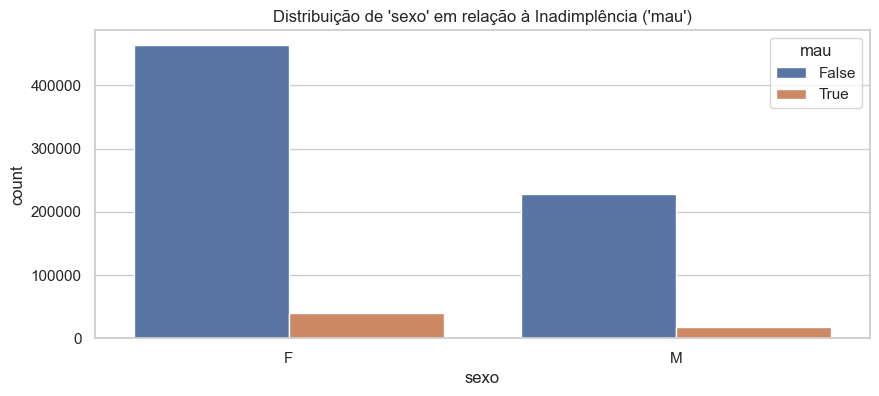

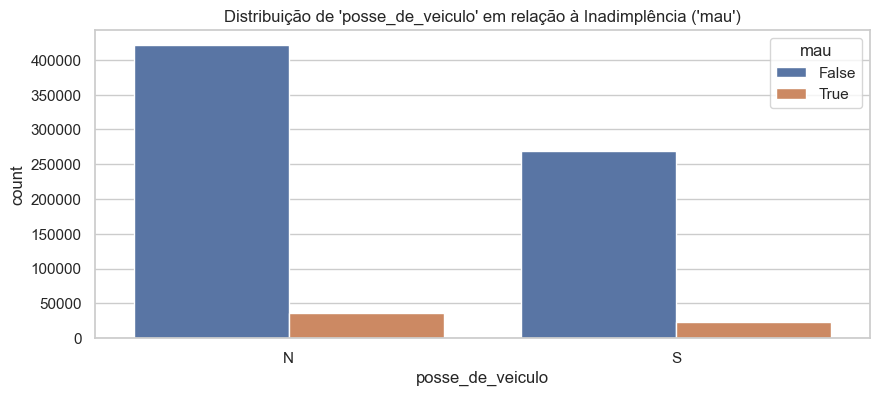

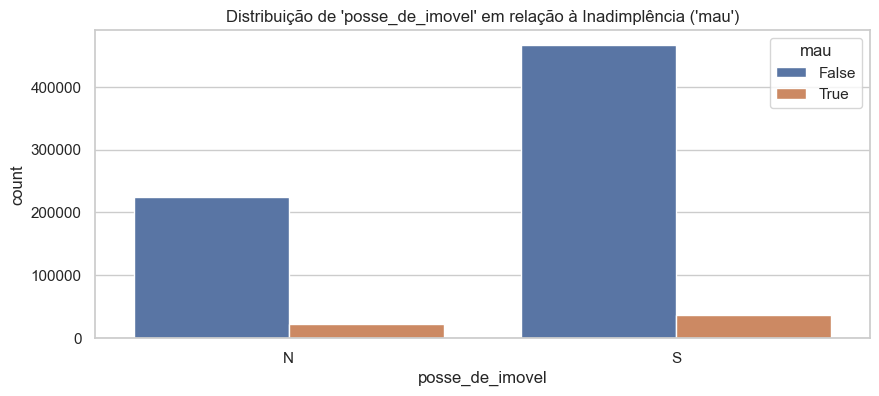

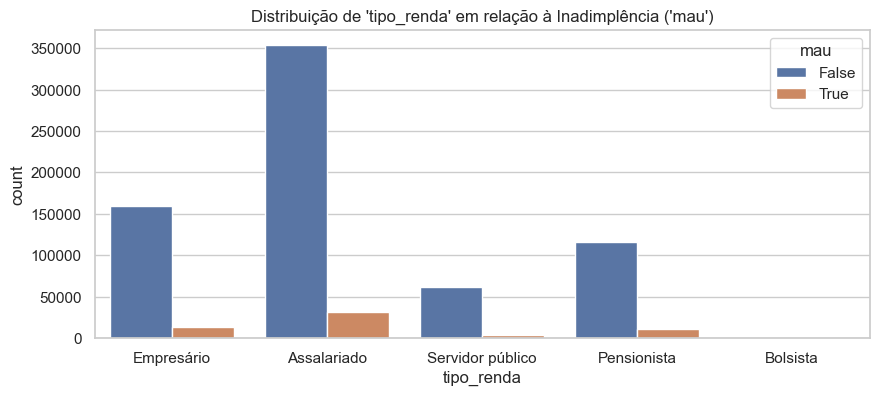

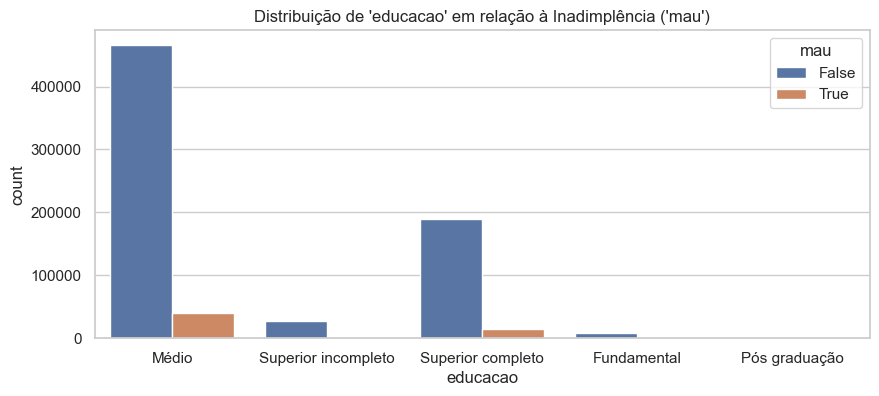

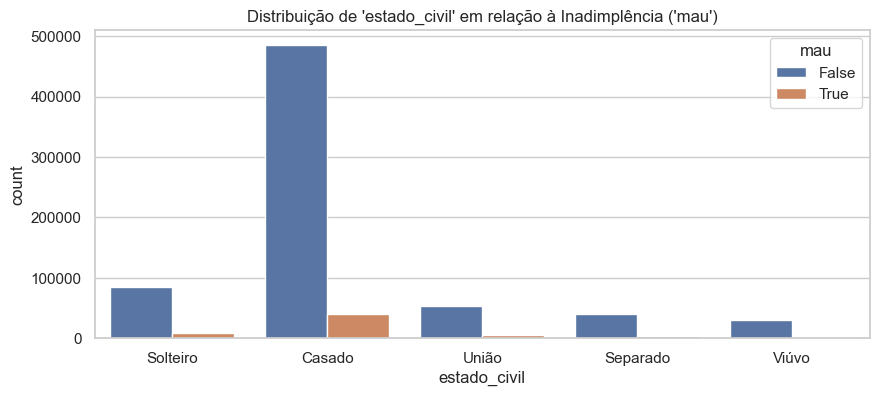

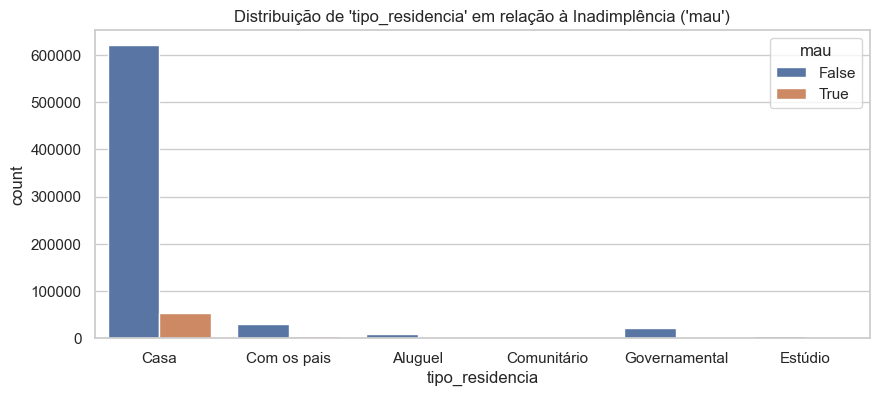

In [7]:
# Para as variáveis quantitativas
sns.set(style="whitegrid")

# Análise bivariada para variáveis qualitativas
for column in qualitative_vars.columns:
    if column != 'mau':  # Excluindo a própria variável alvo
        plt.figure(figsize=(10, 4))
        sns.countplot(x=column, hue="mau", data=df)
        plt.title(f"Distribuição de '{column}' em relação à Inadimplência ('mau')")
        plt.show()

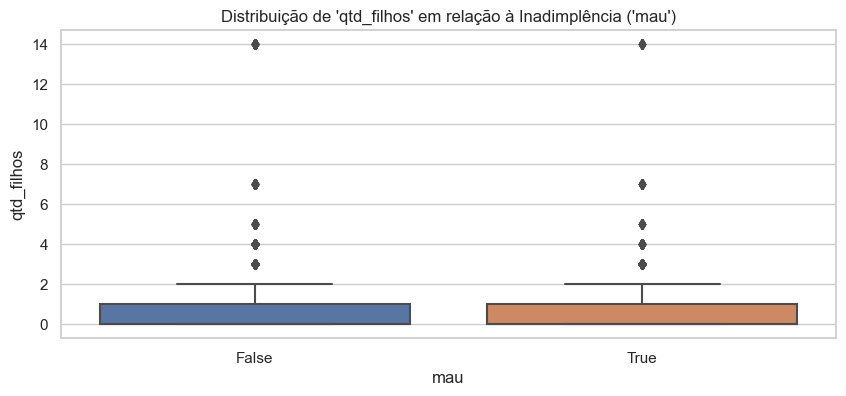

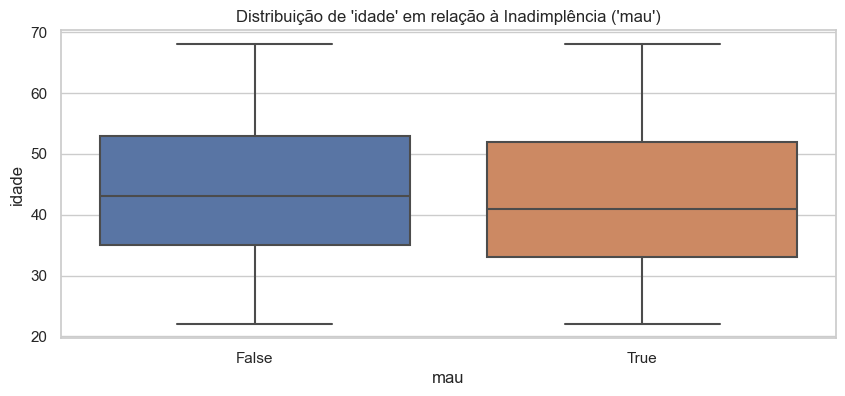

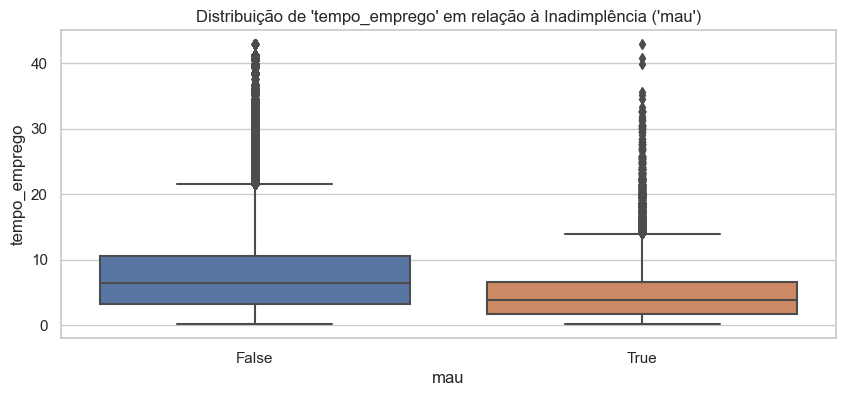

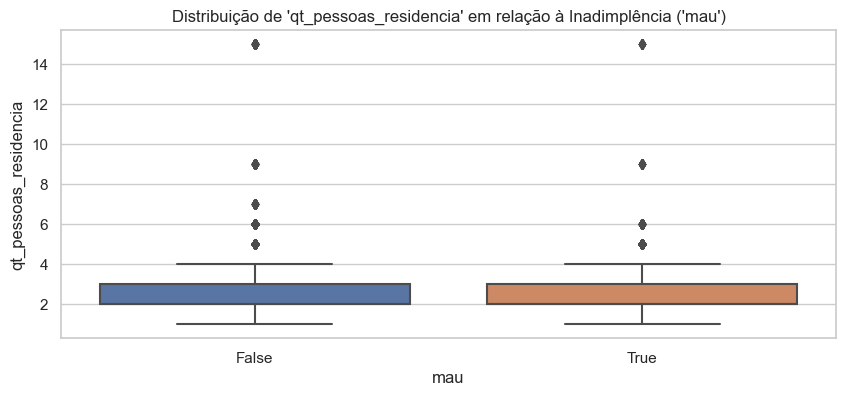

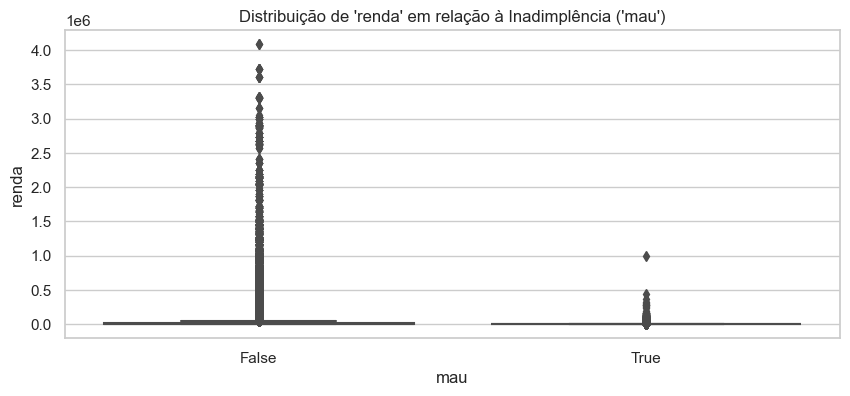

In [8]:
# Análise bivariada para variáveis quantitativas
for column in quantitative_vars.columns:
    if column != 'mau':  # Excluindo a própria variável alvo
        plt.figure(figsize=(10, 4))
        sns.boxplot(x="mau", y=column, data=df)
        plt.title(f"Distribuição de '{column}' em relação à Inadimplência ('mau')")
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
# Identificando valores missing no conjunto de dados
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filtrar apenas as variáveis com missing values
missing_values_percentage = (missing_values / len(df)) * 100

missing_values, missing_values_percentage

(tempo_emprego    125957
 dtype: int64,
 tempo_emprego    16.794267
 dtype: float64)

In [10]:
# Substituindo valores ausentes em 'tempo_emprego' pela mediana
median_tempo_emprego = df['tempo_emprego'].median()
df['tempo_emprego'].fillna(median_tempo_emprego, inplace=True)

# Verificar se ainda existem valores ausentes
df.isnull().sum().max()

0

In [11]:
# Função para calcular IQR e identificar outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound))
    return outliers

# Identificando outliers em cada variável quantitativa
outliers_dict = {column: detect_outliers(df, column) for column in quantitative_vars.columns}

# Calculando o número total de outliers por variável
outliers_count = {column: outliers.sum() for column, outliers in outliers_dict.items()}
outliers_count

{'qtd_filhos': 10016,
 'idade': 0,
 'tempo_emprego': 57123,
 'qt_pessoas_residencia': 9629,
 'renda': 79072}

In [12]:
# Limitando os outliers
for column in quantitative_vars.columns:
    if column != 'idade':  # 'idade' não tem outliers
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Verificando novamente a presença de outliers após a limitação
outliers_dict_post = {column: detect_outliers(df, column) for column in quantitative_vars.columns}
outliers_count_post = {column: outliers.sum() for column, outliers in outliers_dict_post.items()}
outliers_count_post

{'qtd_filhos': 0,
 'idade': 0,
 'tempo_emprego': 0,
 'qt_pessoas_residencia': 0,
 'renda': 0}

In [13]:
# Contando o número de zeros em algumas variáveis quantitativas
zero_counts = {column: (df[column] == 0).sum() for column in quantitative_vars.columns}
zero_counts

{'qtd_filhos': 517331,
 'idade': 0,
 'tempo_emprego': 0,
 'qt_pessoas_residencia': 0,
 'renda': 0}

In [14]:
# Verificando a distribuição das categorias em cada variável qualitativa
category_distributions = {column: df[column].value_counts() for column in qualitative_vars.columns}
category_distributions

{'sexo': F    504580
 M    245420
 Name: sexo, dtype: int64,
 'posse_de_veiculo': N    457954
 S    292046
 Name: posse_de_veiculo, dtype: int64,
 'posse_de_imovel': S    503692
 N    246308
 Name: posse_de_imovel, dtype: int64,
 'tipo_renda': Assalariado         385740
 Empresário          172712
 Pensionista         126265
 Servidor público     64922
 Bolsista               361
 Name: tipo_renda, dtype: int64,
 'educacao': Médio                  506836
 Superior completo      204306
 Superior incompleto     29471
 Fundamental              8575
 Pós graduação             812
 Name: educacao, dtype: int64,
 'estado_civil': Casado      526472
 Solteiro     91659
 União        57685
 Separado     42571
 Viúvo        31613
 Name: estado_civil, dtype: int64,
 'tipo_residencia': Casa             674294
 Com os pais       33232
 Governamental     23440
 Aluguel           10349
 Estúdio            5395
 Comunitário        3290
 Name: tipo_residencia, dtype: int64,
 'mau': False    691357
 Tru

In [15]:
# Agrupando categorias em algumas variáveis qualitativas

# Tipo de Renda: Agrupando 'Bolsista' em 'Outros'
df['tipo_renda'] = df['tipo_renda'].replace('Bolsista', 'Outros')

# Educação: Agrupando 'Fundamental', 'Superior incompleto' e 'Pós graduação' em 'Outros'
education_groups = ['Fundamental', 'Superior incompleto', 'Pós graduação']
df['educacao'] = df['educacao'].replace(education_groups, 'Outros')

# Estado Civil: Agrupando 'Separado' e 'Viúvo' em 'Outros'
civil_status_groups = ['Separado', 'Viúvo']
df['estado_civil'] = df['estado_civil'].replace(civil_status_groups, 'Outros')

# Tipo de Residência: Agrupando 'Estúdio' e 'Comunitário' em 'Outros'
residence_type_groups = ['Estúdio', 'Comunitário']
df['tipo_residencia'] = df['tipo_residencia'].replace(residence_type_groups, 'Outros')

# Verificando a nova distribuição das categorias após o agrupamento
new_category_distributions = {column: df[column].value_counts() for column in qualitative_vars.columns}
new_category_distributions

{'sexo': F    504580
 M    245420
 Name: sexo, dtype: int64,
 'posse_de_veiculo': N    457954
 S    292046
 Name: posse_de_veiculo, dtype: int64,
 'posse_de_imovel': S    503692
 N    246308
 Name: posse_de_imovel, dtype: int64,
 'tipo_renda': Assalariado         385740
 Empresário          172712
 Pensionista         126265
 Servidor público     64922
 Outros                 361
 Name: tipo_renda, dtype: int64,
 'educacao': Médio                506836
 Superior completo    204306
 Outros                38858
 Name: educacao, dtype: int64,
 'estado_civil': Casado      526472
 Solteiro     91659
 Outros       74184
 União        57685
 Name: estado_civil, dtype: int64,
 'tipo_residencia': Casa             674294
 Com os pais       33232
 Governamental     23440
 Aluguel           10349
 Outros             8685
 Name: tipo_residencia, dtype: int64,
 'mau': False    691357
 True      58643
 Name: mau, dtype: int64}

In [16]:
# Criando faixas etárias
bins = [0, 25, 35, 45, 55, 65, float('inf')]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['idade_grupo'] = pd.cut(df['idade'], bins=bins, labels=labels, right=False)

# Verificando a distribuição da nova variável 'idade_grupo'
age_group_distribution = df['idade_grupo'].value_counts().sort_index()
age_group_distribution

18-25      6846
26-35    183420
36-45    217466
46-55    183317
56-65    141883
65+       17068
Name: idade_grupo, dtype: int64

In [17]:
# Preparando os dados para o modelo
X = df.drop(['data_ref', 'index', 'mau', 'idade'], axis=1)  # Excluindo 'data_ref', 'index', 'mau' e 'idade' (usamos 'idade_grupo')
y = df['mau'].astype(int)  # Convertendo a variável alvo para tipo inteiro (0 e 1)

# Codificando variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construindo o modelo de regressão logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Exibindo os coeficientes do modelo
coeficientes = pd.Series(logreg.coef_[0], index=X_train.columns)
intercept = logreg.intercept_[0]

coeficientes, intercept


(qtd_filhos                       0.228325
 tempo_emprego                   -0.027654
 qt_pessoas_residencia           -0.219924
 renda                           -0.000145
 sexo_M                          -0.140852
 posse_de_veiculo_S               0.027273
 posse_de_imovel_S               -0.045485
 tipo_renda_Empresário           -0.074289
 tipo_renda_Outros               -0.000069
 tipo_renda_Pensionista          -0.070930
 tipo_renda_Servidor público     -0.025160
 educacao_Outros                 -0.035202
 educacao_Superior completo      -0.071998
 estado_civil_Outros             -0.170056
 estado_civil_Solteiro           -0.221653
 estado_civil_União               0.005715
 tipo_residencia_Casa            -0.182753
 tipo_residencia_Com os pais     -0.111630
 tipo_residencia_Governamental   -0.075223
 tipo_residencia_Outros          -0.023419
 idade_grupo_26-35               -0.120446
 idade_grupo_36-45               -0.091040
 idade_grupo_46-55               -0.094997
 idade_grup

In [18]:
report = classification_report(y_test, logreg.predict(X_test), zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    207295
           1       0.00      0.00      0.00     17705

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000


In [19]:
# Adicionando uma constante ao conjunto de dados (necessário para o modelo statsmodels)
X_train_sm = sm.add_constant(X_train)

# Construindo o modelo de regressão logística com statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Exibindo o resumo do modelo, incluindo os valores-p
model_summary = result.summary()
print(model_summary)

Optimization terminated successfully.
         Current function value: 0.241754
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               525000
Model:                          Logit   Df Residuals:                   524974
Method:                           MLE   Df Model:                           25
Date:                Thu, 25 Jan 2024   Pseudo R-squ.:                  0.1170
Time:                        19:03:54   Log-Likelihood:            -1.2692e+05
converged:                       True   LL-Null:                   -1.4375e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.3669      0.193     -7.077      0.

1. **Variáveis Significativas**:
   - `tempo_emprego`: Coeficiente negativo, indicando que um maior tempo de emprego está associado a uma menor probabilidade de inadimplência.
   - `renda`: Coeficiente negativo, sugerindo que uma maior renda está associada a uma menor probabilidade de inadimplência.
   - `tipo_renda_Pensionista`: Coeficiente negativo, indicando que ser pensionista está associado a uma menor probabilidade de inadimplência.
   - `idade_grupo_36-45`: Coeficiente negativo, indicando que pertencer a esta faixa etária está associado a uma menor probabilidade de inadimplência em comparação com o grupo base (18-25 anos).

2. **Variáveis Não Significativas**:
   - Variáveis como `qtd_filhos`, `sexo_M`, `posse_de_veiculo_S`, e muitas outras mostraram valores-p altos, indicando que não há evidência suficiente para afirmar que estas variáveis têm um impacto significativo na previsão de inadimplência.

É importante notar que a significância estatística não é o único fator a ser considerado ao avaliar a importância de uma variável em um modelo preditivo. Aspectos como a relevância prática, a interpretabilidade e o conhecimento do domínio também são importantes.

A presença de variáveis não significativas pode indicar que elas não contribuem de maneira útil para o modelo ou que suas relações com a variável alvo são mais complexas do que o modelo linear pode capturar. Em uma análise mais aprofundada, pode-se considerar remover ou substituir variáveis não significativas para simplificar o modelo e potencialmente melhorar seu desempenho.

In [20]:
# Removendo variáveis não significativas
# Identificando as variáveis com valor-p > 0,05 (não significativas)
p_values = result.pvalues
non_significant_vars = p_values[p_values > 0.05].index

# Removendo a constante do conjunto de variáveis não significativas
#non_significant_vars = non_significant_vars.drop('const')

# Atualizando os conjuntos de dados para excluir as variáveis não significativas
X_train_significant = X_train.drop(columns=non_significant_vars)
X_test_significant = X_test.drop(columns=non_significant_vars)

# Reconstruindo o modelo com apenas variáveis significativas
logreg_significant = LogisticRegression(max_iter=1000)
logreg_significant.fit(X_train_significant, y_train)

# Exibindo os coeficientes do novo modelo
coeficientes_significativos = pd.Series(logreg_significant.coef_[0], index=X_train_significant.columns)
intercept_significativo = logreg_significant.intercept_[0]

print(f"Intercepto: {intercept_significativo}")
print(f"Coeficientes: \n {coeficientes_significativos}")

Intercepto: -1.0222028953930133
Coeficientes: 
 tempo_emprego                -0.028229
renda                        -0.000146
sexo_M                       -0.113232
posse_de_veiculo_S            0.080146
posse_de_imovel_S            -0.190082
tipo_renda_Empresário        -0.115590
tipo_renda_Pensionista       -0.169341
educacao_Superior completo   -0.091485
dtype: float64


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [21]:
# Fazendo previsões com o modelo ajustado no conjunto de teste
y_pred = logreg_significant.predict(X_test_significant)
y_pred_proba = logreg_significant.predict_proba(X_test_significant)[:, 1]

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)

# Calculando o índice de Gini
gini = 2 * roc_auc_score(y_test, y_pred_proba) - 1

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculando a estatística KS
ks_statistic = max(tpr - fpr)

accuracy, gini, ks_statistic

(0.9213111111111111, 0.5485346706363505, 0.41412461816442653)

Acurácia: Aproximadamente 92%. Isso indica que o modelo foi capaz de prever corretamente a inadimplência em 92% dos casos no conjunto de teste.
Índice de Gini: Aproximadamente 0.54. O índice de Gini varia de -1 (pior) a 1 (melhor), com 0 indicando um modelo que não tem capacidade de discriminação. Um índice de 0.54 indica uma boa capacidade de discriminação.
Estatística KS: Aproximadamente 0.41. A estatística KS varia de 0 a 1, com valores mais altos indicando melhor capacidade do modelo de distinguir entre as classes (inadimplentes e não inadimplentes). Um valor de 0.41 sugere uma capacidade razoável do modelo em separar as duas classes.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [22]:
# Os nulos já foram substituídos anteriormente, mas para fins de demonstração, vamos criar uma função para substituir nulos

def tratar_valores_nulos(df, metodo='excluir', eixo=0, valor_categoria=None, inplace=False):
    """
    Trata valores nulos em um DataFrame do pandas, com opções para excluir, 
    substituir por média, mediana, moda ou uma categoria específica.

    :param df: DataFrame do pandas.
    :param metodo: Método para tratar valores nulos ('excluir', 'media', 'mediana', 'moda', 'categoria').
    :param eixo: 0 para linhas, 1 para colunas (aplicável apenas quando metodo='excluir'). Padrão é 0.
    :param valor_categoria: Valor para substituir valores nulos em colunas categóricas (aplicável apenas quando metodo='categoria').
    :param inplace: Se True, modifica o DataFrame original. Se False, retorna um novo DataFrame. Padrão é False.
    :return: DataFrame tratado se inplace=False, caso contrário None.
    """
    if metodo == 'excluir':
        resultado = df.dropna(axis=eixo, inplace=inplace)
    else:
        if inplace:
            resultado = None
            for coluna in df.columns:
                if df[coluna].dtype == 'object' and metodo == 'categoria':
                    if valor_categoria is None:
                        raise ValueError("É necessário fornecer um valor para 'valor_categoria' quando o método é 'categoria'.")
                    df[coluna].fillna(valor_categoria, inplace=True)
                else:
                    if metodo == 'media':
                        substituto = df[coluna].mean()
                    elif metodo == 'mediana':
                        substituto = df[coluna].median()
                    elif metodo == 'moda':
                        substituto = df[coluna].mode()[0]
                    df[coluna].fillna(substituto, inplace=True)
        else:
            df_modificado = df.copy()
            for coluna in df_modificado.columns:
                if df_modificado[coluna].dtype == 'object' and metodo == 'categoria':
                    if valor_categoria is None:
                        raise ValueError("É necessário fornecer um valor para 'valor_categoria' quando o método é 'categoria'.")
                    df_modificado[coluna].fillna(valor_categoria, inplace=True)
                else:
                    if metodo == 'media':
                        substituto = df_modificado[coluna].mean()
                    elif metodo == 'mediana':
                        substituto = df_modificado[coluna].median()
                    elif metodo == 'moda':
                        substituto = df_modificado[coluna].mode()[0]
                    df_modificado[coluna].fillna(substituto, inplace=True)
            resultado = df_modificado

    return resultado


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [23]:
# Já fizemos o trataemnto de outliers anteriormente, mas para fins de demonstração, vamos criar uma função para remover outliers
def tratar_outliers(df, metodo='excluir', metrica=None, limite_inferior=None, limite_superior=None):
    """
    Trata valores outliers em um DataFrame do pandas.

    :param df: DataFrame do pandas.
    :param metodo: Método para tratar outliers ('excluir', 'metrica', 'restringir').
    :param metrica: Métrica para substituição ('media', 'mediana', 'moda') - aplicável se metodo='metrica'.
    :param limite_inferior: Limite inferior para os valores - aplicável se metodo='restringir'.
    :param limite_superior: Limite superior para os valores - aplicável se metodo='restringir'.
    :return: DataFrame com outliers tratados.
    """
    df_modificado = df.copy()

    for coluna in df.columns:
        if df[coluna].dtype != 'object':  # Tratar apenas colunas numéricas
            Q1 = df[coluna].quantile(0.25)
            Q3 = df[coluna].quantile(0.75)
            IQR = Q3 - Q1
            filtro = (df[coluna] >= Q1 - 1.5 * IQR) & (df[coluna] <= Q3 + 1.5 * IQR)

            if metodo == 'excluir':
                df_modificado = df_modificado[filtro]
            elif metodo == 'metrica':
                if metrica == 'media':
                    substituto = df[coluna].mean()
                elif metrica == 'mediana':
                    substituto = df[coluna].median()
                elif metrica == 'moda':
                    substituto = df[coluna].mode()[0]
                df_modificado.loc[~filtro, coluna] = substituto
            elif metodo == 'restringir':
                if limite_inferior is not None:
                    df_modificado.loc[df[coluna] < limite_inferior, coluna] = limite_inferior
                if limite_superior is not None:
                    df_modificado.loc[df[coluna] > limite_superior, coluna] = limite_superior

    return df_modificado


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [28]:

# Criando cópias do DataFrame para manipulação
df_encoded = df.drop(columns=["index", "data_ref"]).copy()

# Aplicando Label Encoding nas variáveis categóricas
label_encoders = {}
for column in df_encoded.select_dtypes(include=['object', 'category', 'datetime']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

# Definindo a variável alvo e as variáveis de entrada
X = df_encoded.drop('mau', axis=1)
y = df_encoded['mau']

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Substituindo valores NaN pela mediana de cada coluna
for coluna in X_train.columns:
    median_value = X_train[coluna].median()
    X_train[coluna].fillna(median_value, inplace=True)
    X_test[coluna].fillna(median_value, inplace=True)

# Treinando o modelo Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Obtendo importâncias das características
feature_importances = rf_classifier.feature_importances_

# Criando um DataFrame para facilitar a visualização das importâncias
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
11,renda,0.726939
9,tempo_emprego,0.098458
8,idade,0.067662
4,tipo_renda,0.013913
6,estado_civil,0.012924
10,qt_pessoas_residencia,0.012546
5,educacao,0.011638
12,idade_grupo,0.011343
1,posse_de_veiculo,0.010832
7,tipo_residencia,0.009394


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [29]:
# Padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Criando um DataFrame para os componentes do PCA
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(5)])
pca_df.head()


,PC1,PC2,PC3,PC4,PC5
0,-0.893056,-1.868143,1.153835,0.933604,0.551624
1,0.570639,-0.864361,-0.317963,-0.494682,-0.761841
2,3.155276,-0.235050,-1.425660,2.060769,0.991062
3,-1.195817,0.609670,0.569764,0.352901,0.981844
4,0.716353,-1.908982,2.131746,-0.182996,-0.029103


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [33]:
df_pipeline

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,idade_grupo
0,F,N,N,0.0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,36-45
1,F,S,S,0.0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,36-45
2,F,N,N,2.0,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,26-35
3,F,N,N,0.0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,46-55
4,F,S,N,0.0,Assalariado,Outros,Solteiro,Casa,31,8.432877,1.0,2891.08,False,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0.0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False,46-55
749996,F,N,S,0.0,Pensionista,Médio,Solteiro,Casa,65,6.046575,1.0,1389.39,False,65+
749997,M,S,N,2.0,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True,36-45
749998,F,N,S,0.0,Assalariado,Médio,Outros,Casa,56,13.780822,1.0,4216.72,True,56-65


In [35]:

# Uma outra forma de tratar os outliers
# Definindo a classe personalizada para remover outliers
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.mean_ = X.mean()
            self.std_ = X.std()
        else:
            self.mean_ = pd.Series(X.mean(axis=0))
            self.std_ = pd.Series(X.std(axis=0))
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_copy = X.copy()
            for col in X_copy.columns:
                upper_bound = self.mean_[col] + self.n_std * self.std_[col]
                lower_bound = self.mean_[col] - self.n_std * self.std_[col]
                X_copy[col] = X_copy[col].clip(lower_bound, upper_bound)
            return X_copy
        else:
            X_copy = pd.DataFrame(X).copy()
            for col in range(X_copy.shape[1]):
                upper_bound = self.mean_[col] + self.n_std * self.std_[col]
                lower_bound = self.mean_[col] - self.n_std * self.std_[col]
                X_copy[col] = X_copy[col].clip(lower_bound, upper_bound)
            return X_copy.values

# Colunas para OneHot Encoding
categorical_cols = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 
                    'educacao', 'estado_civil', 'tipo_residencia']

# Aplicamos o OneHotEncoder às variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Mantém as outras colunas não listadas
)

# Construindo o pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),               # Primeiro o pré-processador
    ('imputer', SimpleImputer(strategy='median')),  # Depois o tratamento de valores nulos
    ('outliers', OutlierRemover()),                # Remoção de outliers
    ('pca', PCA(n_components=5))                   # Aplicação de PCA
])


# Removendo colunas 'index' e 'data_ref'
df_pipeline = df.drop(['index', 'data_ref', 'idade_grupo'], axis=1)

# Aplicando o pipeline
pipeline.fit_transform(df_pipeline)



array([[-1.05198246e+04,  3.47597373e-01,  2.16637758e+00,
        -1.68760761e+00, -4.29560341e-01],
       [-9.85502590e+03, -7.85686261e+00,  9.47034231e-02,
        -4.88603540e-01,  3.40542293e-01],
       [-1.14529272e+04, -1.19922176e+01, -3.57286061e+00,
         1.74692277e+00, -1.27180300e+00],
       ...,
       [-1.23861538e+04,  5.51683554e-01,  6.12215269e+00,
         2.45887500e+00,  8.75176203e-01],
       [-8.81849194e+03,  1.34956262e+01,  8.05893456e+00,
        -1.11059471e+00, -3.30886060e-01],
       [-8.57452393e+03,  1.51148632e-01,  5.31539099e+00,
         2.46659173e+00,  8.69696073e-01]])

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [36]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [40]:
from pycaret.classification import *

# Inicializando o ambiente no PyCaret e configurando o pré-processamento
clf = setup(data=df, target='mau', session_id=123,
            ignore_features=['index', 'data_ref'], # Ignorando as colunas 'index' e 'data_ref'
            categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 
                                  'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
            numeric_imputation='median',           # Substituição de valores nulos pela mediana
            normalize=True,                       # Normalização dos dados
            transformation=True,
            verbose=False)                  # Transformação dos dados (ex.: remoção de outliers)

# Treinando o modelo LightGBM
lightgbm_model = create_model('lightgbm')


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:13:47
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

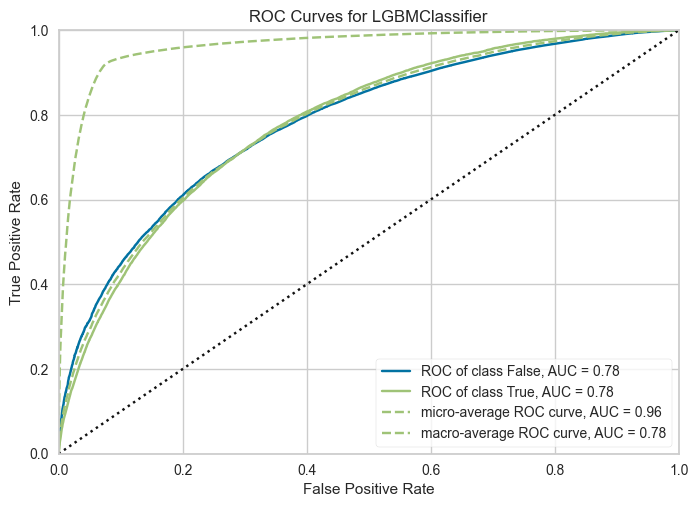

In [41]:
# Plot AUC
plot_model(lightgbm_model, plot='auc')

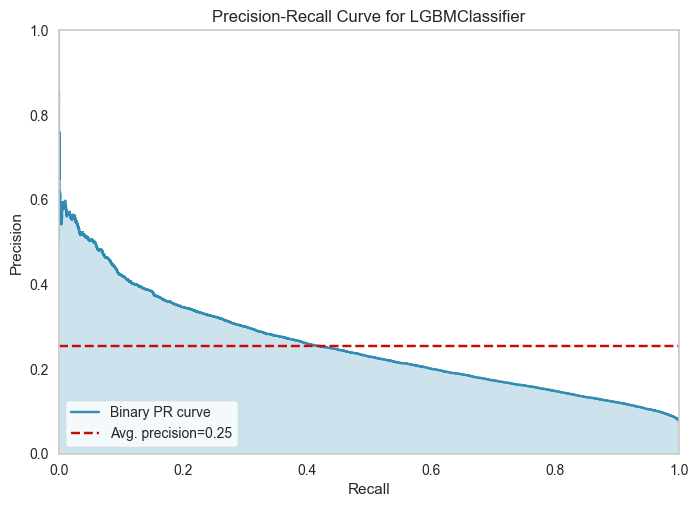

In [42]:
# Precision Recall
plot_model(lightgbm_model, plot='pr')


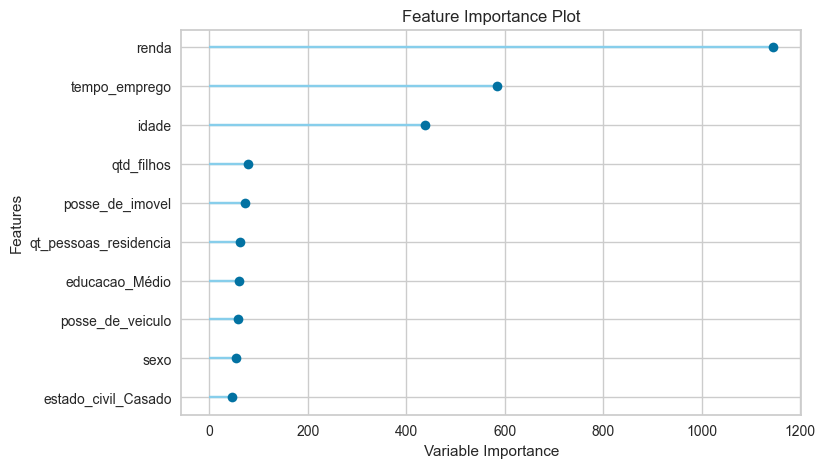

In [43]:
# Feature Importance
plot_model(lightgbm_model, plot='feature')

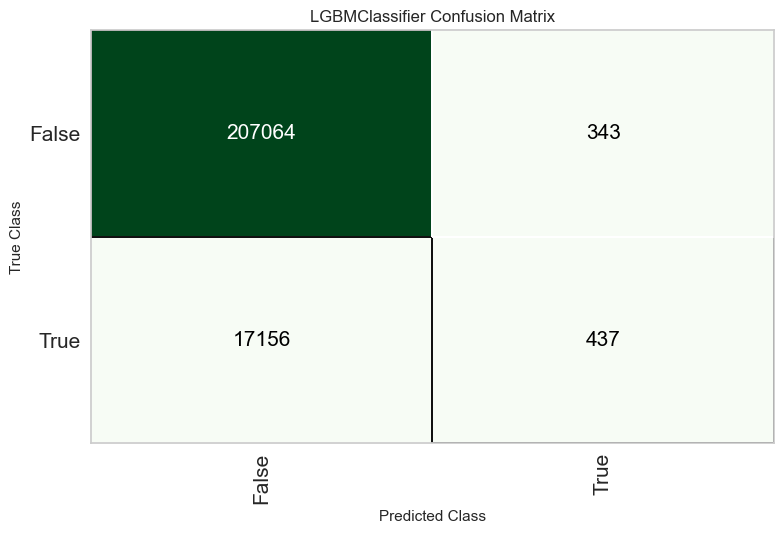

In [44]:
# Matrix Confusion
plot_model(lightgbm_model, plot = 'confusion_matrix')

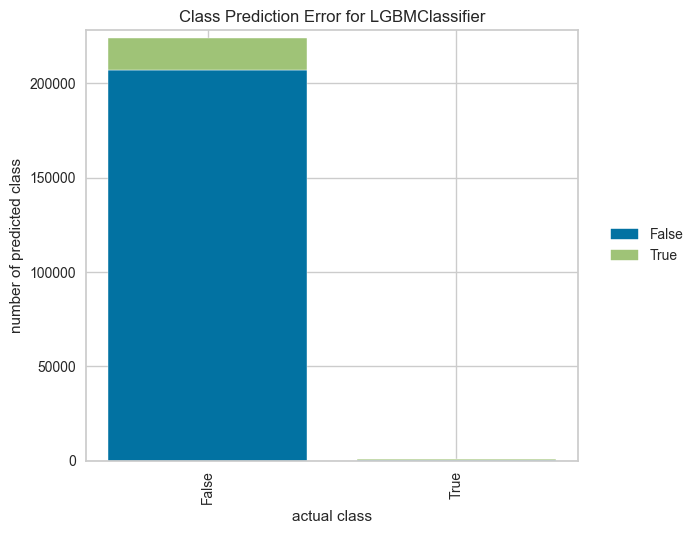

In [45]:
# Class Prediction Error
plot_model(lightgbm_model, plot='error')

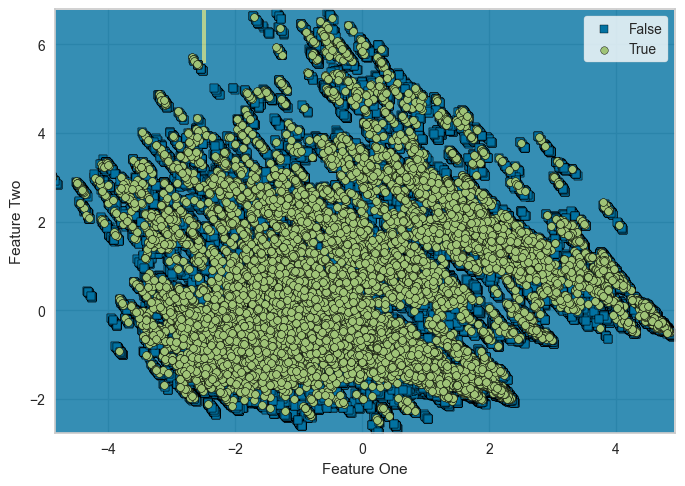

In [48]:
# Decision Boundary
plot_model(lightgbm_model, plot='boundary')